In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import en_core_web_trf

In [2]:
# Load data
column_names = ["Sentence", "Label"]
df_train_sen_lab = pd.read_csv('../datasets_cleaned/train_cleaned.txt', sep='\t', header=None, names=column_names)

# Load Spacy model
nlp = spacy.load("en_core_web_trf")

In [3]:
# Additional terms for entity extraction
additional_terms = {"person", "man", "woman", "police", "administration", "immigrants",
                   "president", "minister", "senator", "representative", "governor", "mayor", "council", "secretary", "ambassador",
                   "chancellor", "parliamentary"}

In [4]:
pronouns = {"i", "me", "myself", "you", "yourself", "he", "she", "him", "her", "they", "them", "himself", "herself", "themself"}

In [5]:
def find_interacting_entities(doc):
    # Define the priority labels for entities to be extracted
    priority_labels = ["PERSON", "NORP", "ORG", "GPE"]
    valid_entities = []

    for label in priority_labels:
        # If we already have two different entities, stop searching
        if len(valid_entities) >= 2:
            if valid_entities[0][2].lower() != valid_entities[1][2].lower(): break # 2 entities cant be the same entities 

        # Extract entities matching the current priority label
        current_entities = [(ent.start_char, ent.end_char, ent.text) for ent in doc.ents if ent.label_ == label]
        valid_entities.extend(current_entities)

        # Additional check for PERSON label: include tokens from additional terms if fewer than 2 entities found
        if label == "PERSON" and len(valid_entities) < 2:
            for token in doc:
                if token.text.lower() in additional_terms:
                    valid_entities.append((token.idx, token.idx + len(token.text), token.text))

        # Additional check after the last label: include tokens from pronouns if fewer than 2 entities found
        if label == "GPE" and len(valid_entities) < 2:
            for token in doc:
                if token.text.lower() in pronouns:
                    valid_entities.append((token.idx, token.idx + len(token.text), token.text))

        # Sort entities by their start position
        valid_entities = sorted(valid_entities, key=lambda x: x[0])

        # Merge adjacent entities
        merged_entities = []
        i = 0
        while i < len(valid_entities):
            current_ent = valid_entities[i]
            j = i + 1
            while j < len(valid_entities) and valid_entities[j][0] <= current_ent[1] + 1:
                current_ent = (current_ent[0], valid_entities[j][1], current_ent[2] + " " + valid_entities[j][2])
                j += 1
            merged_entities.append(current_ent)
            i = j
        valid_entities = merged_entities

    # Return the first two entities if available
    if len(valid_entities) >= 2:
        return valid_entities[:2]
    else:
        return valid_entities



def wrap_selected_entities(text):
    doc = nlp(text)
    entities = find_interacting_entities(doc)
    
    formatted_text = text
    offset = 0
    for ent in entities:
        start, end, ent_text = ent
        start += offset
        end += offset
        formatted_text = formatted_text[:start] + '[' + ent_text + ']' + formatted_text[end:]
        offset += 2  # 2 characters for the added brackets

    # Construct the final formatted text with entity details
    entity_count = len(entities)
    if entity_count == 0:
        formatted_text = formatted_text + "\t" + "0" + "\t" + "None" + "\t" + "None"
    elif entity_count == 1:
        formatted_text = formatted_text + "\t" + "1" + "\t" + entities[0][2] + "\t" + "None"
    else:
        formatted_text = formatted_text + "\t" + "2" + "\t" + entities[0][2] + "\t" + entities[1][2]
    
    return formatted_text

In [6]:
# Apply the function to the 'Sentence' column with sentence numbering
df_train_sen_lab['Formatted_Sentence'] = df_train_sen_lab.apply(lambda row: wrap_selected_entities(row['Sentence']), axis=1)

In [7]:
# Select the relevant columns
df_train_Form_sen_lab_sen_lab = df_train_sen_lab[['Formatted_Sentence', 'Label']]

# Split the 'Formatted_Sentence' column into multiple columns
split_columns = df_train_Form_sen_lab_sen_lab['Formatted_Sentence'].str.split("\t", expand=True)

# Assign the new columns to the DataFrame and rename them
df_train_Form_sen_lab_sen_lab["Formatted_Sentence"] = split_columns[0]
df_train_Form_sen_lab_sen_lab["Num_of_ent"] = split_columns[1].astype(int)
df_train_Form_sen_lab_sen_lab["Ent_1"] = split_columns[2]
df_train_Form_sen_lab_sen_lab["Ent_2"] = split_columns[3]

# Select and reorder the final columns
df_train_Form_sen_lab_sen_lab = df_train_Form_sen_lab_sen_lab[["Formatted_Sentence", "Ent_1", "Ent_2", "Num_of_ent", "Label"]]

# Save the new dataframe
file_path = '../datasets_new_nered/train_new_ner.txt'
df_train_Form_sen_lab_sen_lab.to_csv(file_path, sep='\t', index=False, header=None)

C:\Users\Anastasiia Belkina\AppData\Local\Temp\ipykernel_11292\3933166657.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_Form_sen_lab_sen_lab["Formatted_Sentence"] = split_columns[0]


In [8]:
df_train_Form_sen_lab_sen_lab

,Formatted_Sentence,Ent_1,Ent_2,Num_of_ent,Label
0,A [Los Angeles] news anchor said earlier this ...,Los Angeles,the United States,2,0
1,"President [Trump], who has often called for fe...",Trump,Kasich,2,0
2,"[Cotton] and other lawmakers, including Speake...",Cotton,Paul Ryan,2,0
3,Congress initially passed waivers to the terro...,Bush,Obama,2,0
4,"Sorry Mr. [Brooks], Democrats aren't creating ...",Brooks,immigrants,2,0
...,...,...,...,...,...
13139,But [Bruce] would also jump at the chance to a...,Bruce,Wolves,2,1
13140,[NIANTIC] has introduced more Shiny Pokemon th...,NIANTIC,Yokosuka,2,1
13141,There is still violence in Basra but [British]...,British,Iraqi,2,1
13142,"However, [Turkish] officials said they recogni...",Turkish,Prakash,2,3


In [9]:
# take only those rows, where Num_of_ent = 2
ent = [2]
mask = df_train_Form_sen_lab_sen_lab['Num_of_ent'].isin(ent)
df_train_Form_sen_lab_sen_lab_2 = df_train_Form_sen_lab_sen_lab[mask]
df_train_Form_sen_lab_sen_lab_2 = df_train_Form_sen_lab_sen_lab_2.drop(columns=['Num_of_ent'])

In [10]:
file_path = '../datasets_new_nered_2_ents/train.txt'
df_train_Form_sen_lab_sen_lab_2.to_csv(file_path, sep='\t', index=False, header=None)

**В скольких случаях моя и их разметка различается?**

In [11]:
df_train_Form_sen_lab_sen_lab

,Formatted_Sentence,Ent_1,Ent_2,Num_of_ent,Label
0,A [Los Angeles] news anchor said earlier this ...,Los Angeles,the United States,2,0
1,"President [Trump], who has often called for fe...",Trump,Kasich,2,0
2,"[Cotton] and other lawmakers, including Speake...",Cotton,Paul Ryan,2,0
3,Congress initially passed waivers to the terro...,Bush,Obama,2,0
4,"Sorry Mr. [Brooks], Democrats aren't creating ...",Brooks,immigrants,2,0
...,...,...,...,...,...
13139,But [Bruce] would also jump at the chance to a...,Bruce,Wolves,2,1
13140,[NIANTIC] has introduced more Shiny Pokemon th...,NIANTIC,Yokosuka,2,1
13141,There is still violence in Basra but [British]...,British,Iraqi,2,1
13142,"However, [Turkish] officials said they recogni...",Turkish,Prakash,2,3


In [12]:
column_names = ["Sentence", "Ent_1", "Ent_2", "Label"]
df_train_other_ner = pd.read_csv('../dataset/train.txt', sep='\t', header=None, names=column_names)

In [13]:
column_names = ["Sentence", "Label"]
df_train_clean = pd.read_csv('../datasets_cleaned/train_cleaned.txt', sep='\t', header=None, names=column_names)

In [31]:
# Create the new DataFrame
df_comparing = pd.DataFrame({
    "sentense_clean": df_train_Form_sen_lab_sen_lab["Formatted_Sentence"],
    "my_ent_1": df_train_Form_sen_lab_sen_lab["Ent_1"],
    "their_ent_1": df_train_other_ner["Ent_1"],
    "my_ent_2": df_train_Form_sen_lab_sen_lab["Ent_2"],
    "their_ent_2": df_train_other_ner["Ent_2"],
    "label": df_train_clean["Label"]  # Assuming label is the same across DataFrames
})

# Show only rows where entities don't match
df_comparing_wrong = df_comparing[
    (df_comparing["my_ent_1"] != df_comparing["their_ent_1"]) |
    (df_comparing["my_ent_2"] != df_comparing["their_ent_2"])
]

# Show only rows where entities match
df_comparing_right = df_comparing[
    (df_comparing["my_ent_1"] == df_comparing["their_ent_1"]) &
    (df_comparing["my_ent_2"] == df_comparing["their_ent_2"])
]

In [32]:
df_comparing

,sentense_clean,my_ent_1,their_ent_1,my_ent_2,their_ent_2,label
0,A [Los Angeles] news anchor said earlier this ...,Los Angeles,Los Angele,the United States,the United State,0
1,"President [Trump], who has often called for fe...",Trump,Trump,Kasich,Kasich’,0
2,"[Cotton] and other lawmakers, including Speake...",Cotton,Paul Ryan,Paul Ryan,U. S.,0
3,Congress initially passed waivers to the terro...,Bush,Congre,Obama,Bush,0
4,"Sorry Mr. [Brooks], Democrats aren't creating ...",Brooks,Democrat,immigrants,American,0
...,...,...,...,...,...,...
13139,But [Bruce] would also jump at the chance to a...,Bruce,Bruce,Wolves,Wolve,1
13140,[NIANTIC] has introduced more Shiny Pokemon th...,NIANTIC,NIANTIC,Yokosuka,Pokemon,1
13141,There is still violence in Basra but [British]...,British,British,Iraqi,Iraqi,1
13142,"However, [Turkish] officials said they recogni...",Turkish,Turkish,Prakash,Prakash’s Australian,3


In [33]:
df_comparing_wrong

,sentense_clean,my_ent_1,their_ent_1,my_ent_2,their_ent_2,label
0,A [Los Angeles] news anchor said earlier this ...,Los Angeles,Los Angele,the United States,the United State,0
1,"President [Trump], who has often called for fe...",Trump,Trump,Kasich,Kasich’,0
2,"[Cotton] and other lawmakers, including Speake...",Cotton,Paul Ryan,Paul Ryan,U. S.,0
3,Congress initially passed waivers to the terro...,Bush,Congre,Obama,Bush,0
4,"Sorry Mr. [Brooks], Democrats aren't creating ...",Brooks,Democrat,immigrants,American,0
...,...,...,...,...,...,...
13136,Some [Illinois] delegates wound up taking test...,Illinois,Illinoi,Ford,Ford,4
13138,"Adding to the global tightening, under pressur...",Fed,the European Central Bank,the Bank of Japan,QE,3
13139,But [Bruce] would also jump at the chance to a...,Bruce,Bruce,Wolves,Wolve,1
13140,[NIANTIC] has introduced more Shiny Pokemon th...,NIANTIC,NIANTIC,Yokosuka,Pokemon,1


In [34]:
df_comparing_wrong.to_csv('df_comparing_wrong_new.csv', index=False)

In [35]:
df_comparing_right

,sentense_clean,my_ent_1,their_ent_1,my_ent_2,their_ent_2,label
6,NOTHING [SUPREME Court] Justice [Ruth Bader G...,SUPREME Court,SUPREME Court,Ruth Bader Ginsburg,Ruth Bader Ginsburg,0
11,This support was so strong that these voters n...,Reagan,Reagan,Republican,Republican,0
12,But if [Manent] does not hold anyone up to bla...,Manent,Manent,French,French,0
14,A WiFi network at a [Donald Trump] rally was n...,Donald Trump,Donald Trump,Democratic,Democratic,0
22,[Nasir Abdullahi] is sitting in a mall in down...,Nasir Abdullahi,Nasir Abdullahi,Abuja,Abuja,0
...,...,...,...,...,...,...
13129,"[Sudan] accepted a 10,000-strong [UN] force to...",Sudan,Sudan,UN,UN,1
13132,[North Korea] itself maintains its missile dev...,North Korea,North Korea,the U. S.,the U. S.,3
13137,"And people make mistakes, but I think it was a...",Trump,Trump,Merkel,Merkel,3
13141,There is still violence in Basra but [British]...,British,British,Iraqi,Iraqi,1


**Надо умудриться выделить только те, что у нас одинаковые или хотя бы примерно**

In [36]:
# Create the new DataFrame
df_clean_all_same_together = pd.DataFrame({
    "sentense_clean": df_comparing_right["sentense_clean"],
    "my_ent_1": df_comparing_right["my_ent_1"],
    "my_ent_2": df_comparing_right["my_ent_2"],
    "label": df_comparing_right["label"]  # Assuming label is the same across DataFrames
})

In [37]:
df_clean_all_same_together

,sentense_clean,my_ent_1,my_ent_2,label
6,NOTHING [SUPREME Court] Justice [Ruth Bader G...,SUPREME Court,Ruth Bader Ginsburg,0
11,This support was so strong that these voters n...,Reagan,Republican,0
12,But if [Manent] does not hold anyone up to bla...,Manent,French,0
14,A WiFi network at a [Donald Trump] rally was n...,Donald Trump,Democratic,0
22,[Nasir Abdullahi] is sitting in a mall in down...,Nasir Abdullahi,Abuja,0
...,...,...,...,...
13129,"[Sudan] accepted a 10,000-strong [UN] force to...",Sudan,UN,1
13132,[North Korea] itself maintains its missile dev...,North Korea,the U. S.,3
13137,"And people make mistakes, but I think it was a...",Trump,Merkel,3
13141,There is still violence in Basra but [British]...,British,Iraqi,1


In [38]:
df = pd.read_csv('kinda_same_indexes.txt', header=None)
# Convert DataFrame to a numpy array
indexes_array = df[0].to_numpy()

In [39]:
df_comparing_wrong_kinda_same = df_comparing_wrong.iloc[indexes_array][["sentense_clean", "my_ent_1", "my_ent_2", "label"]]
# Concatenate the DataFrames
df_combined = pd.concat([df_clean_all_same_together, df_comparing_wrong_kinda_same], ignore_index=True)

In [40]:
df_combined

,sentense_clean,my_ent_1,my_ent_2,label
0,NOTHING [SUPREME Court] Justice [Ruth Bader G...,SUPREME Court,Ruth Bader Ginsburg,0
1,This support was so strong that these voters n...,Reagan,Republican,0
2,But if [Manent] does not hold anyone up to bla...,Manent,French,0
3,A WiFi network at a [Donald Trump] rally was n...,Donald Trump,Democratic,0
4,[Nasir Abdullahi] is sitting in a mall in down...,Nasir Abdullahi,Abuja,0
...,...,...,...,...
5027,Renewed tension has been growing between the t...,Buddhist,Muslims,3
5028,", [Miller] said she felt violated by his remar...",Miller,Phillips,3
5029,[Thomas] is bluntly accusing his colleagues o...,Thomas,Mellouli,3
5030,Some [Illinois] delegates wound up taking test...,Illinois,Ford,4


In [41]:
# Shuffle the DataFrame
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [42]:
label_counts = df_combined['label'].value_counts()

In [43]:
label_counts

label
0    2733
3    1311
1     670
4     190
2     128
Name: count, dtype: int64

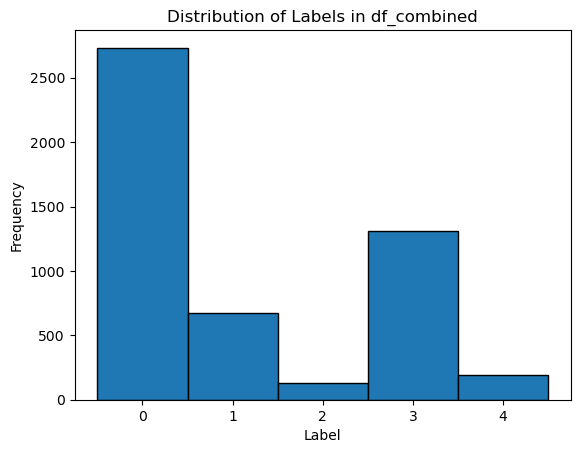

In [44]:
import matplotlib.pyplot as plt

# Plotting the histogram for the 'label' column
plt.hist(df_combined['label'], bins=range(df_combined['label'].min(), df_combined['label'].max() + 2), edgecolor='black', align='left')

# Adding title and labels
plt.title('Distribution of Labels in df_combined')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [45]:
# Save the new dataframe
file_path = '../datasets_only_same_ents_clean/train_with_scobes.txt'
df_combined.to_csv(file_path, sep='\t', index=False, header=None)